# CS 4501 - Project 3 Part 2: Leduc Poker + RL Algorithms

Rishi Shah, Yash Kolli, Tarun Donipati

In this project, our team explores the applications of reinforcement learning to Leduc poker, a simplified variation of poker involving face card combinations. We first initialize two objects that are key to our game — balance and card. Each player starts with a balance of 100.

In [120]:
import random

class HumanPlayer:
    def __init__(self, balance, card, wins):
        self.balance = balance
        self.card = card
        self.wins = wins

class AIPlayer:
    def __init__(self, balance, card, wins, epsilon, alpha, state):
        self.balance = balance
        self.card = card
        self.wins = wins
        self.epsilon = epsilon
        self.alpha = alpha
        self.state = state

In [121]:
state = {
            'KK0': .5, 'KK1': .5, 'KK01': .5, 'KK10': .5, 'KK11': .5, 'KK00': .5, 'KK010': .5, 'KK011': .5,
            'QQ0': .5, 'QQ1': .5, 'QQ01': .5, 'QQ10': .5, 'QQ11': .5, 'QQ00': .5, 'QQ010': .5, 'QQ011': .5,
            'JJ0': .5, 'JJ1': .5, 'JJ01': .5, 'JJ10': .5, 'JJ11': .5, 'JJ00': .5, 'JJ010': .5, 'JJ011': .5,
            'KQ0': .5, 'KQ1': .5, 'KQ01': .5, 'KQ10': .5, 'KQ11': .5, 'KQ00': .5, 'KQ010': .5, 'KQ011': .5,
            'QK0': .5, 'QK1': .5, 'QK01': .5, 'QK10': .5, 'QK11': .5, 'QK00': .5, 'QK010': .5, 'QK011': .5,
            'KJ0': .5, 'KJ1': .5, 'KJ01': .5, 'KJ10': .5, 'KJ11': .5, 'KJ00': .5, 'KJ010': .5, 'KJ011': .5,
            'JK0': .5, 'JK1': .5, 'JK01': .5, 'JK10': .5, 'JK11': .5, 'JK00': .5, 'JK010': .5, 'JK011': .5,
            'QJ0': .5, 'QJ1': .5, 'QJ01': .5, 'QJ10': .5, 'QJ11': .5, 'QJ00': .5, 'QJ010': .5, 'QJ011': .5, 
            'JQ0': .5, 'JQ1': .5, 'JQ01': .5, 'JQ10': .5, 'JQ11': .5, 'JQ00': .5, 'JQ010': .5, 'JQ011': .5,
        }

In the cell below, we lay out the rules of the game. Leduc poker is a two-player game where each player receives a face card (K, Q, J), and a community card of some face is chosen at random. The objective of the game is to have your card match with the community card to create the pairing of the highest value.

The pair values progress as follows — KK, QQ, JJ, KQ, KJ, QJ — where KK represents the highest value while QJ represents the lowest value. We thus order our values ordinally, where KK = 5, QQ = 4, JJ = 3, KQ = 2, KJ = 1, and QJ = 0. 

The game progresses as follows. First, Player 1 and Player 2 are each given a random face card (K, Q, or J). Simultaneously, a community card is chosen at random. When each player decides to partake in the game, they transfer 1 unit of their balance to the pot. Each player can only see their card and the community card, and must decide whether to increase the pot by betting more or to hold their balance by checking or folding.

A player has four moves to make in each game: raise, check, call, or fold. A rational player raises when they predict having a high chance of winning. For example, if I saw that I have a KK pair, I would raise the pot as much as possible, as that would result in a higher gain for me. Raising is the only attacking move that a player can make in poker. Checking is used by the player when they don't want to raise the pot more.

Call and fold are both reactionary moves to a raise. A rational player would call a bet when they believe that they have a good chance of winning. For example, if I have a KK pair and my opponent raised the pot, I would call the pot to stay in the game. A player would fold when they believe that they don't have a high chance of winning. For example, if I have a QJ pair and my opponent raises, I would fold to make sure that I don't lose more money than what I already contributed to the pot.

In this game, there are 8 decision sequences (0, 1, 01, 10, 11, 00, 010, 011). 0 and 1 are primary moves in the game. 0 represents a check, while 1 represents a bet. 01, 10, 11, and 00 are secondary moves. When Player 1 makes 0 as his first move, 01 is a bet made by Player 2, while 00 is a check made by Player 2. If Player 1 makes 1 as his first move, 11 is a bet made by Player 2, while 10 is a check made by Player 2. Finally, 010 and 011 are tertiary moves. Given that Player 2 bet after player 1 checked, 010 is Player 1 making a check, while 011 is Player 1 making a bet.

Within this game, there are 72 states that our RL agent must learn. These are each of the 9 pairs (KK, QQ, JJ, KQ, QK, KJ, JK, QJ, JQ) multiplied by the 8 possible decision sequences (0, 1, 01, 10, 11, 00, 010, 011).

In [122]:
def showdownValue(card, community):
    
    ranks = {
        'KK': 6,
        'QQ': 5,
        'JJ': 4,
        'KQ': 3, 'QK': 3,
        'KJ': 2, 'JK': 2,
        'QJ': 1, 'JQ': 1
    }

    hand = card+community
    return ranks[hand]

The following cell is used to normalize winning probablities for pairs of actions.

In [123]:
def normalize(bet, check):
    if bet < 0:
        return 0, 1
    
    if check < 0:
        return 1, 0
    
    #print(bet, check)
    
    if bet + check > 0:
        bet /= (bet + check)
        check /= (bet + check)
        
    elif bet + check == 0:
        bet = 0.5
        check = 0.5
        
    #print(bet, check)
    
    return bet, check

Below, we have randomized the game. Now, Player 1 and Player 2 make random actions where each action has a set reward. The player picks a random decision sequence given his card pairing. Given the result of the game, the player updates his probability distribution using epsilon to find the optimal state that maximizes his potential to win.

In [124]:
def LeducPokerRandomChoices(Player1, Player2):
    
    # initialize cards
    cards = ['J', 'J', 'Q', 'Q', 'K', 'K']
    
    # initialize money pot
    pot = 0
    
    # randomly assign cards
    s = random.sample(cards, 3)

    Player1.card = s[0]
    Player2.card = s[1]
    community_card = s[2]
    
    
    p1 = [Player1.card + community_card]
    p2 = [Player2.card + community_card]
    
    p1b = Player1.balance
    p2b = Player2.balance
    
    # add initial ante to the pot
    Player1.balance -= 1
    Player2.balance -= 1
    pot += 2
    
    
    # first action by Player 1
    if Player1.state[p1[0] + '1'] > Player1.state[p1[0] + '0']:
        if random.random() > Player1.epsilon:
            player1_action1 = 1
        else:
            player1_action1 = 0
    
    elif Player1.state[p1[0] + '1'] < Player1.state[p1[0] + '0']:
        if random.random() > Player1.epsilon:
            player1_action1 = 0
        else:
            player1_action1 = 1
    
    else:
        player1_action1 = round(random.random())
    
    
    p1[0] += str(player1_action1)
    p2[0] += str(player1_action1)
    
    
    # execute if Player 1 checks
    if player1_action1 == 0:
        
        # first action by Player 2
        if Player2.state[p2[0] + '1'] > Player2.state[p2[0] + '0']:
            if random.random() > Player2.epsilon:
                player2_action1 = 1
            else:
                player2_action1 = 0
    
        elif Player2.state[p2[0] + '1'] < Player2.state[p2[0] + '0']:
            if random.random() > Player2.epsilon:
                player2_action1 = 0
            else:
                player2_action1 = 1
    
        else:
            player2_action1 = round(random.random())
            
        p1.append(p1[0] + str(player2_action1))
        p2.append(p2[0] + str(player2_action1))
        
        # execute if Player 2 checks
        if player2_action1 == 0:
    
            # showdown for the pot
        
            # Player 1 wins
            if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                Player1.balance += pot
                pot = 0
                Player1.wins += 1
                
                for i in range(len(p1)):
                    Player1.state[p1[i]] += Player1.alpha*(Player1.balance-p1b)
                    Player2.state[p2[i]] -=  Player2.alpha*(p2b-Player2.balance)
                    
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'] = normalize(Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]] = normalize(Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'] = normalize(Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]] = normalize(Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]])
                
            
            # Player 2 wins            
            elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                Player2.balance += pot
                pot = 0
                Player2.wins += 1
                
                for i in range(len(p1)):
                    Player2.state[p2[i]] += Player2.alpha*(Player2.balance-p2b)
                    Player1.state[p1[i]] -= Player1.alpha*(p1b-Player1.balance)
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'] = normalize(Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]] = normalize(Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'] = normalize(Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]] = normalize(Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]])
                
            # Tie Game
            else:
                Player1.balance += pot/2
                Player2.balance += pot/2
                pot = 0
        
        # execute if Player 2 bets
        if player2_action1 == 1:
            
            # add to the pot from Player 2
            Player2.balance -= 1
            pot += 1
            
            # second action by Player 1
            if Player1.state[p1[1] + '1'] > Player1.state[p1[1] + '0']:
                if random.random() > Player1.epsilon:
                    player1_action2 = 1
                else:
                    player1_action2 = 0
    
            elif Player1.state[p1[1] + '1'] < Player1.state[p1[1] + '0']:
                if random.random() > Player1.epsilon:
                    player1_action2 = 0
                else:
                    player1_action2 = 1
    
            else:
                player1_action2 = round(random.random())
                
            p1.append(p1[1] + str(player1_action2))
            p2.append(p2[1] + str(player1_action2))
            
            # execute if Player 1 folds
            if player1_action2 == 0:
                Player2.balance += pot
                pot = 0
                Player2.wins += 1
                for i in range(len(p1)):
                    Player2.state[p2[i]] += Player2.alpha*(Player2.balance-p2b)
                    Player1.state[p1[i]] -= Player1.alpha*(p1b-Player1.balance)
                    
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'] = normalize(Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]] = normalize(Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'] = normalize(Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]] = normalize(Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]])
                
        
            # execute if Player 1 calls
            if player1_action2 == 1:
            
                # add to the pot from Player 1
                Player1.balance -= 1
                pot += 1
            
                # showdown for the pot
                
                # Player 1 wins
                if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                    Player1.balance += pot
                    pot = 0
                    Player1.wins += 1
                    for i in range(len(p1)):
                        Player1.state[p1[i]] += Player1.alpha*(Player1.balance-p1b)
                        Player2.state[p2[i]] -=  Player2.alpha*(p2b-Player2.balance)
                        
                        
                        if p1[i][-1] == '1':
                            Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'] = normalize(Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'])
                        
                        else:
                            Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]] = normalize(Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]])
                        
                        if p2[i][-1] == '1':
                            Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'] = normalize(Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'])
                        
                        else:
                            Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]] = normalize(Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]])
                    
                
            
                # Player 2 wins            
                elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                    Player2.balance += pot
                    pot = 0
                    Player2.wins += 1
                    for i in range(len(p1)):
                        Player2.state[p2[i]] += Player2.alpha*(Player2.balance-p2b)
                        Player1.state[p1[i]] -= Player1.alpha*(p1b-Player1.balance)
                        
                        
                        if p1[i][-1] == '1':
                            Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'] = normalize(Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'])
                        
                        else:
                            Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]] = normalize(Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]])
                        
                        if p2[i][-1] == '1':
                            Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'] = normalize(Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'])
                        
                        else:
                            Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]] = normalize(Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]])
                    
                    
                
                # Tie Game
                else:
                    Player1.balance += pot/2
                    Player2.balance += pot/2
                    pot = 0
            
    
    # execute if Player 1 bets
    if player1_action1 == 1:
        
        # add to the pot from Player 1
        Player1.balance -= 1
        pot += 1
        
        # first action by Player 2
        if Player2.state[p2[0] + '1'] > Player2.state[p2[0] + '0']:
            if random.random() > Player2.epsilon:
                player2_action1 = 1
            else:
                player2_action1 = 0
    
        elif Player2.state[p2[0] + '1'] < Player2.state[p2[0] + '0']:
            if random.random() > Player2.epsilon:
                player2_action1 = 0
            else:
                player2_action1 = 1
    
        else:
            player2_action1 = round(random.random())
            
        p1.append(p1[0] + str(player2_action1))
        p2.append(p2[0] + str(player2_action1))
        
        # execute if Player 2 folds
        if player2_action1 == 0:
            Player1.balance += pot
            pot = 0
            Player1.wins += 1
            for i in range(len(p1)):
                Player1.state[p1[i]] += Player1.alpha*(Player1.balance-p1b)
                Player2.state[p2[i]] -=  Player2.alpha*(p2b-Player2.balance)
                
                
                if p1[i][-1] == '1':
                    Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'] = normalize(Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'])
                        
                else:
                    Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]] = normalize(Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]])
                        
                if p2[i][-1] == '1':
                    Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'] = normalize(Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'])
                        
                else:
                    Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]] = normalize(Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]])
            
        
        # execute if Player 2 calls
        if player2_action1 == 1:
            
            # add to the pot from Player 2
            Player2.balance -= 1
            pot += 1
            
            # showdown for the pot
                
            # Player 1 wins
            if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                Player1.balance += pot
                pot = 0
                Player1.wins += 1
                for i in range(len(p1)):
                    Player1.state[p1[i]] += Player1.alpha*(Player1.balance-p1b)
                    Player2.state[p2[i]] -=  Player2.alpha*(p2b-Player2.balance)
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'] = normalize(Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]] = normalize(Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'] = normalize(Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]] = normalize(Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]])
                
            
            # Player 2 wins            
            elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                Player2.balance += pot
                pot = 0
                Player2.wins += 1
                for i in range(len(p1)):
                    Player2.state[p2[i]] += Player2.alpha*(Player2.balance-p2b)
                    Player1.state[p1[i]] -= Player1.alpha*(p1b-Player1.balance)
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'] = normalize(Player1.state[p1[i]], Player1.state[p1[i][0:-1] + '0'])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]] = normalize(Player1.state[p1[i][0:-1] + '1'], Player1.state[p1[i]])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'] = normalize(Player2.state[p2[i]], Player2.state[p2[i][0:-1] + '0'])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]] = normalize(Player2.state[p2[i][0:-1] + '1'], Player2.state[p2[i]])
            
            # Tie Game
            else:
                Player1.balance += pot/2
                Player2.balance += pot/2
                pot = 0

In [125]:
def train(epochs, p1, p2):
    
    for i in range(1, epochs + 1):
        LeducPokerRandomChoices(p1, p2)
        LeducPokerRandomChoices(p2, p1)
        
        '''if i % 2 == 1:
            LeducPokerRandomChoices(Player1, Player2)
        else:
            LeducPokerRandomChoices(Player2, Player1)'''
    
    print(Player1.wins, Player1.balance)
    print(Player2.wins, Player2.balance)
    return (Player1.state, Player2.state)
    # print(Player2.state)
    
def compete(epochs, p1, p2):
    for i in range(1, epochs + 1):
        LeducPokerRandomChoices(p1, p2)
        LeducPokerRandomChoices(p2, p1)
    print(Player1.wins, Player1.balance)
    print(Player2.wins, Player2.balance)

Below, you will find a state dictionary with keys of each state and value of probabilities that each player should play. We have initialized most of these states at 0.5, representing a random probability of choosing that state. However, some states such ask KK1 are set as 1 because these are states which are mandatory for the player to play. Similarly we have set some at 0 as these are states we don't want the AI to choose. As such, we are guiding the AI to make certain decisions given our understanding of strategy in this game.

In [126]:
s1 = {
            'KK0': .5, 'KK1': 1, 'KK01': .5, 'KK10': 1, 'KK11': 1, 'KK00': 1, 'KK010': 0, 'KK011': 1,
            'QQ0': .5, 'QQ1': 1, 'QQ01': .5, 'QQ10': 1, 'QQ11': 1, 'QQ00': 1, 'QQ010': 0, 'QQ011': 1,
            'JJ0': .5, 'JJ1': 1, 'JJ01': .5, 'JJ10': 1, 'JJ11': 1, 'JJ00': 1, 'JJ010': 0, 'JJ011': 1,
            'KQ0': .5, 'KQ1': .5, 'KQ01': .5, 'KQ10': 1, 'KQ11': .5, 'KQ00': .5, 'KQ010': 0, 'KQ011': .5,
            'QK0': .5, 'QK1': .5, 'QK01': .5, 'QK10': 1, 'QK11': .5, 'QK00': .5, 'QK010': 0, 'QK011': .5,
            'KJ0': .5, 'KJ1': .5, 'KJ01': .5, 'KJ10': 1, 'KJ11': .5, 'KJ00': .5, 'KJ010': 0, 'KJ011': .5,
            'JK0': .5, 'JK1': .5, 'JK01': .5, 'JK10': 1, 'JK11': .5, 'JK00': .5, 'JK010': 0, 'JK011': .5,
            'QJ0': .5, 'QJ1': .5, 'QJ01': .5, 'QJ10': 1, 'QJ11': .5, 'QJ00': .5, 'QJ010': 0, 'QJ011': .5, 
            'JQ0': .5, 'JQ1': .5, 'JQ01': .5, 'JQ10': 1, 'JQ11': .5, 'JQ00': .5, 'JQ010': 0, 'JQ011': .5,
        }

s2 = {
            'KK0': .5, 'KK1': .5, 'KK01': 1, 'KK10': 0, 'KK11': 1, 'KK00': 1, 'KK010': 1, 'KK011': 1,
            'QQ0': .5, 'QQ1': .5, 'QQ01': 1, 'QQ10': 0, 'QQ11': 1, 'QQ00': 1, 'QQ010': 1, 'QQ011': 1,
            'JJ0': .5, 'JJ1': .5, 'JJ01': 1, 'JJ10': 0, 'JJ11': 1, 'JJ00': 1, 'JJ010': 1, 'JJ011': 1,
            'KQ0': .5, 'KQ1': .5, 'KQ01': .5, 'KQ10': 0, 'KQ11': .5, 'KQ00': .5, 'KQ010': 1, 'KQ011': .5,
            'QK0': .5, 'QK1': .5, 'QK01': .5, 'QK10': 0, 'QK11': .5, 'QK00': .5, 'QK010': 1, 'QK011': .5,
            'KJ0': .5, 'KJ1': .5, 'KJ01': .5, 'KJ10': 0, 'KJ11': .5, 'KJ00': .5, 'KJ010': 1, 'KJ011': .5,
            'JK0': .5, 'JK1': .5, 'JK01': .5, 'JK10': 0, 'JK11': .5, 'JK00': .5, 'JK010': 1, 'JK011': .5,
            'QJ0': .5, 'QJ1': .5, 'QJ01': .5, 'QJ10': 0, 'QJ11': .5, 'QJ00': .5, 'QJ010': 1, 'QJ011': .5, 
            'JQ0': .5, 'JQ1': .5, 'JQ01': .5, 'JQ10': 0, 'JQ11': .5, 'JQ00': .5, 'JQ010': 1, 'JQ011': .5,
        }





Player1 = AIPlayer(1000, '', 0, 0.1, 0.005, s1)
Player2 = AIPlayer(1000, '', 0, 0.1, 0.005, s2)

s1, s2 = train(100000, Player1, Player2)

Player1 = AIPlayer(1000, '', 0, 0, 0, s1)
Player2 = AIPlayer(1000, '', 0, 0, 0, s2)

compete(100000, Player1, Player2)


78843 -50413.0
102288 52413.0
79923 -52600.0
106727 54600.0


In the function above, we trained our RL agent against another RL agent and had them compete against each other. In the function below, we create a human vs. computer interface, where we allow you to play against our RL agent.

In [127]:
def LeducPokerProbabilities(Player1, Player2):
    
    # initialize cards
    cards = ['J', 'J', 'Q', 'Q', 'K', 'K']
    
    # initialize money pot
    pot = 0
    
    # randomly assign cards
    s = random.sample(cards, 3)

    Player1.card = s[0]
    Player2.card = s[1]
    community_card = s[2]
    
    
    p1 = [Player1.card + community_card]
    p2 = [Player2.card + community_card]
      
    p1b = Player1.balance
    p2b = Player2.balance
    
    # add initial ante to the pot
    Player1.balance -= 1
    Player2.balance -= 1
    pot += 2
    
    
    # first action by Player 1
    if Player1.state[p1[0] + '1'][-1] > Player1.state[p1[0] + '0'][-1]:
        if random.random() > Player1.epsilon:
            player1_action1 = 1
        else:
            player1_action1 = 0
    
    elif Player1.state[p1[0] + '1'][-1] < Player1.state[p1[0] + '0'][-1]:
        if random.random() > Player1.epsilon:
            player1_action1 = 0
        else:
            player1_action1 = 1
    
    else:
        player1_action1 = round(random.random())
    
    
    p1[0] += str(player1_action1)
    p2[0] += str(player1_action1)
    
    
    # execute if Player 1 checks
    if player1_action1 == 0:
        
        # first action by Player 2
        if Player2.state[p2[0] + '1'][-1] > Player2.state[p2[0] + '0'][-1]:
            if random.random() > Player2.epsilon:
                player2_action1 = 1
            else:
                player2_action1 = 0
    
        elif Player2.state[p2[0] + '1'][-1] < Player2.state[p2[0] + '0'][-1]:
            if random.random() > Player2.epsilon:
                player2_action1 = 0
            else:
                player2_action1 = 1
    
        else:
            player2_action1 = round(random.random())
            
        p1.append(p1[0] + str(player2_action1))
        p2.append(p2[0] + str(player2_action1))
        
        # execute if Player 2 checks
        if player2_action1 == 0:
    
            # showdown for the pot
        
            # Player 1 wins
            if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                Player1.balance += pot
                pot = 0
                Player1.wins += 1
                
                for i in range(len(p1)):
                    Player1.state[p1[i]].append(Player1.state[p1[i]][-1] + Player1.alpha*(Player1.balance-p1b))
                    Player2.state[p2[i]].append(Player2.state[p2[i]][-1] - Player2.alpha*(p2b-Player2.balance))
                    
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1] = normalize(Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1] = normalize(Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1] = normalize(Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1] = normalize(Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1])
                
            
            # Player 2 wins            
            elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                Player2.balance += pot
                pot = 0
                Player2.wins += 1
                
                for i in range(len(p1)):
                    Player1.state[p1[i]].append(Player1.state[p1[i]][-1] - Player1.alpha*(p1b-Player1.balance))
                    Player2.state[p2[i]].append(Player2.state[p2[i]][-1] + Player2.alpha*(Player2.balance-p2b))
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1] = normalize(Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1] = normalize(Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1] = normalize(Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1] = normalize(Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1])
                
            # Tie Game
            else:
                Player1.balance += pot/2
                Player2.balance += pot/2
                pot = 0
        
        # execute if Player 2 bets
        if player2_action1 == 1:
            
            # add to the pot from Player 2
            Player2.balance -= 1
            pot += 1
            
            # second action by Player 1
            if Player1.state[p1[1] + '1'][-1] > Player1.state[p1[1] + '0'][-1]:
                if random.random() > Player1.epsilon:
                    player1_action2 = 1
                else:
                    player1_action2 = 0
    
            elif Player1.state[p1[1] + '1'][-1] < Player1.state[p1[1] + '0'][-1]:
                if random.random() > Player1.epsilon:
                    player1_action2 = 0
                else:
                    player1_action2 = 1
    
            else:
                player1_action2 = round(random.random())
                
            p1.append(p1[1] + str(player1_action2))
            p2.append(p2[1] + str(player1_action2))
            
            # execute if Player 1 folds
            if player1_action2 == 0:
                Player2.balance += pot
                pot = 0
                Player2.wins += 1
                for i in range(len(p1)):
                    Player1.state[p1[i]].append(Player1.state[p1[i]][-1] - Player1.alpha*(p1b-Player1.balance))
                    Player2.state[p2[i]].append(Player2.state[p2[i]][-1] + Player2.alpha*(Player2.balance-p2b))
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1] = normalize(Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1] = normalize(Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1] = normalize(Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1] = normalize(Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1])
                
        
            # execute if Player 1 calls
            if player1_action2 == 1:
            
                # add to the pot from Player 1
                Player1.balance -= 1
                pot += 1
            
                # showdown for the pot
                
                # Player 1 wins
                if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                    Player1.balance += pot
                    pot = 0
                    Player1.wins += 1
                    for i in range(len(p1)):
                        Player1.state[p1[i]].append(Player1.state[p1[i]][-1] + Player1.alpha*(Player1.balance-p1b))
                        Player2.state[p2[i]].append(Player2.state[p2[i]][-1] - Player2.alpha*(p2b-Player2.balance))
                    
                        if p1[i][-1] == '1':
                            Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1] = normalize(Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1])
                        
                        else:
                            Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1] = normalize(Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1])
                        
                        if p2[i][-1] == '1':
                            Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1] = normalize(Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1])
                        
                        else:
                            Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1] = normalize(Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1])
                    
                
            
                # Player 2 wins            
                elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                    Player2.balance += pot
                    pot = 0
                    Player2.wins += 1
                    for i in range(len(p1)):
                        Player1.state[p1[i]].append(Player1.state[p1[i]][-1] - Player1.alpha*(p1b-Player1.balance))
                        Player2.state[p2[i]].append(Player2.state[p2[i]][-1] + Player2.alpha*(Player2.balance-p2b))
                    
                        if p1[i][-1] == '1':
                            Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1] = normalize(Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1])
                        
                        else:
                            Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1] = normalize(Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1])
                        
                        if p2[i][-1] == '1':
                            Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1] = normalize(Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1])
                        
                        else:
                            Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1] = normalize(Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1])
                    
                    
                
                # Tie Game
                else:
                    Player1.balance += pot/2
                    Player2.balance += pot/2
                    pot = 0
            
    
    # execute if Player 1 bets
    if player1_action1 == 1:
        
        # add to the pot from Player 1
        Player1.balance -= 1
        pot += 1
        
        # first action by Player 2
        if Player2.state[p2[0] + '1'][-1] > Player2.state[p2[0] + '0'][-1]:
            if random.random() > Player2.epsilon:
                player2_action1 = 1
            else:
                player2_action1 = 0
    
        elif Player2.state[p2[0] + '1'][-1] < Player2.state[p2[0] + '0'][-1]:
            if random.random() > Player2.epsilon:
                player2_action1 = 0
            else:
                player2_action1 = 1
    
        else:
            player2_action1 = round(random.random())
            
        p1.append(p1[0] + str(player2_action1))
        p2.append(p2[0] + str(player2_action1))
        
        # execute if Player 2 folds
        if player2_action1 == 0:
            Player1.balance += pot
            pot = 0
            Player1.wins += 1
            for i in range(len(p1)):
                Player1.state[p1[i]].append(Player1.state[p1[i]][-1] + Player1.alpha*(Player1.balance-p1b))
                Player2.state[p2[i]].append(Player2.state[p2[i]][-1] - Player2.alpha*(p2b-Player2.balance))
                    
                if p1[i][-1] == '1':
                    Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1] = normalize(Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1])
                        
                else:
                    Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1] = normalize(Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1])
                        
                if p2[i][-1] == '1':
                    Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1] = normalize(Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1])
                        
                else:
                    Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1] = normalize(Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1])
            
        
        # execute if Player 2 calls
        if player2_action1 == 1:
            
            # add to the pot from Player 2
            Player2.balance -= 1
            pot += 1
            
            # showdown for the pot
                
            # Player 1 wins
            if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                Player1.balance += pot
                pot = 0
                Player1.wins += 1
                for i in range(len(p1)):
                    Player1.state[p1[i]].append(Player1.state[p1[i]][-1] + Player1.alpha*(Player1.balance-p1b))
                    Player2.state[p2[i]].append(Player2.state[p2[i]][-1] - Player2.alpha*(p2b-Player2.balance))
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1] = normalize(Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1] = normalize(Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1] = normalize(Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1] = normalize(Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1])
                
            
            # Player 2 wins            
            elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                Player2.balance += pot
                pot = 0
                Player2.wins += 1
                for i in range(len(p1)):
                    Player1.state[p1[i]].append(Player1.state[p1[i]][-1] - Player1.alpha*(p1b-Player1.balance))
                    Player2.state[p2[i]].append(Player2.state[p2[i]][-1] + Player2.alpha*(Player2.balance-p2b))
                    
                    if p1[i][-1] == '1':
                        Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1] = normalize(Player1.state[p1[i]][-1], Player1.state[p1[i][0:-1] + '0'][-1])
                        
                    else:
                        Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1] = normalize(Player1.state[p1[i][0:-1] + '1'][-1], Player1.state[p1[i]][-1])
                        
                    if p2[i][-1] == '1':
                        Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1] = normalize(Player2.state[p2[i]][-1], Player2.state[p2[i][0:-1] + '0'][-1])
                        
                    else:
                        Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1] = normalize(Player2.state[p2[i][0:-1] + '1'][-1], Player2.state[p2[i]][-1])
            
            # Tie Game
            else:
                Player1.balance += pot/2
                Player2.balance += pot/2
                pot = 0

In [128]:
# s1 = {
#             'KK0': [.5], 'KK1': [1], 'KK01': [.5], 'KK10': [1], 'KK11': [1], 'KK00': [1], 'KK010': [0], 'KK011': [1],
#             'QQ0': [.5], 'QQ1': [1], 'QQ01': [.5], 'QQ10': [1], 'QQ11': [1], 'QQ00': [1], 'QQ010': [0], 'QQ011': [1],
#             'JJ0': [.5], 'JJ1': [1], 'JJ01': [.5], 'JJ10': [1], 'JJ11': [1], 'JJ00': [1], 'JJ010': [0], 'JJ011': [1],
#             'KQ0': [.5], 'KQ1': [.5], 'KQ01': [.5], 'KQ10': [1], 'KQ11': [.5], 'KQ00': [.5], 'KQ010': [0], 'KQ011': [.5],
#             'QK0': [.5], 'QK1': [.5], 'QK01': [.5], 'QK10': [1], 'QK11': [.5], 'QK00': [.5], 'QK010': [0], 'QK011': [.5],
#             'KJ0': [.5], 'KJ1': [.5], 'KJ01': [.5], 'KJ10': [1], 'KJ11': [.5], 'KJ00': [.5], 'KJ010': [0], 'KJ011': [.5],
#             'JK0': [.5], 'JK1': [.5], 'JK01': [.5], 'JK10': [1], 'JK11': [.5], 'JK00': [.5], 'JK010': [0], 'JK011': [.5],
#             'QJ0': [.5], 'QJ1': [.5], 'QJ01': [.5], 'QJ10': [1], 'QJ11': [.5], 'QJ00': [.5], 'QJ010': [0], 'QJ011': [.5], 
#             'JQ0': [.5], 'JQ1': [.5], 'JQ01': [.5], 'JQ10': [1], 'JQ11': [.5], 'JQ00': [.5], 'JQ010': [0], 'JQ011': [.5],
#         }

# s2 = {
#             'KK0': [.5], 'KK1': [1], 'KK01': [.5], 'KK10': [1], 'KK11': [1], 'KK00': [1], 'KK010': [0], 'KK011': [1],
#             'QQ0': [.5], 'QQ1': [1], 'QQ01': [.5], 'QQ10': [1], 'QQ11': [1], 'QQ00': [1], 'QQ010': [0], 'QQ011': [1],
#             'JJ0': [.5], 'JJ1': [1], 'JJ01': [.5], 'JJ10': [1], 'JJ11': [1], 'JJ00': [1], 'JJ010': [0], 'JJ011': [1],
#             'KQ0': [.5], 'KQ1': [.5], 'KQ01': [.5], 'KQ10': [1], 'KQ11': [.5], 'KQ00': [.5], 'KQ010': [0], 'KQ011': [.5],
#             'QK0': [.5], 'QK1': [.5], 'QK01': [.5], 'QK10': [1], 'QK11': [.5], 'QK00': [.5], 'QK010': [0], 'QK011': [.5],
#             'KJ0': [.5], 'KJ1': [.5], 'KJ01': [.5], 'KJ10': [1], 'KJ11': [.5], 'KJ00': [.5], 'KJ010': [0], 'KJ011': [.5],
#             'JK0': [.5], 'JK1': [.5], 'JK01': [.5], 'JK10': [1], 'JK11': [.5], 'JK00': [.5], 'JK010': [0], 'JK011': [.5],
#             'QJ0': [.5], 'QJ1': [.5], 'QJ01': [.5], 'QJ10': [1], 'QJ11': [.5], 'QJ00': [.5], 'QJ010': [0], 'QJ011': [.5], 
#             'JQ0': [.5], 'JQ1': [.5], 'JQ01': [.5], 'JQ10': [1], 'JQ11': [.5], 'JQ00': [.5], 'JQ010': [0], 'JQ011': [.5],
#      }
s1 = {
            'KK0': [.5], 'KK1': [.5], 'KK01': [.5], 'KK10': [.5], 'KK11': [.5], 'KK00': [.5], 'KK010': [.5], 'KK011': [.5],
            'QQ0': [.5], 'QQ1': [.5], 'QQ01': [.5], 'QQ10': [.5], 'QQ11': [.5], 'QQ00': [.5], 'QQ010': [.5], 'QQ011': [.5],
            'JJ0': [.5], 'JJ1': [.5], 'JJ01': [.5], 'JJ10': [.5], 'JJ11': [.5], 'JJ00': [.5], 'JJ010': [.5], 'JJ011': [.5],
            'KQ0': [.5], 'KQ1': [.5], 'KQ01': [.5], 'KQ10': [.5], 'KQ11': [.5], 'KQ00': [.5], 'KQ010': [.5], 'KQ011': [.5],
            'QK0': [.5], 'QK1': [.5], 'QK01': [.5], 'QK10': [.5], 'QK11': [.5], 'QK00': [.5], 'QK010': [.5], 'QK011': [.5],
            'KJ0': [.5], 'KJ1': [.5], 'KJ01': [.5], 'KJ10': [.5], 'KJ11': [.5], 'KJ00': [.5], 'KJ010': [.5], 'KJ011': [.5],
            'JK0': [.5], 'JK1': [.5], 'JK01': [.5], 'JK10': [.5], 'JK11': [.5], 'JK00': [.5], 'JK010': [.5], 'JK011': [.5],
            'QJ0': [.5], 'QJ1': [.5], 'QJ01': [.5], 'QJ10': [.5], 'QJ11': [.5], 'QJ00': [.5], 'QJ010': [.5], 'QJ011': [.5], 
            'JQ0': [.5], 'JQ1': [.5], 'JQ01': [.5], 'JQ10': [.5], 'JQ11': [.5], 'JQ00': [.5], 'JQ010': [.5], 'JQ011': [.5],
        }

s2 = {
            'KK0': [.5], 'KK1': [.5], 'KK01': [.5], 'KK10': [.5], 'KK11': [.5], 'KK00': [.5], 'KK010': [.5], 'KK011': [.5],
            'QQ0': [.5], 'QQ1': [.5], 'QQ01': [.5], 'QQ10': [.5], 'QQ11': [.5], 'QQ00': [.5], 'QQ010': [.5], 'QQ011': [.5],
            'JJ0': [.5], 'JJ1': [.5], 'JJ01': [.5], 'JJ10': [.5], 'JJ11': [.5], 'JJ00': [.5], 'JJ010': [.5], 'JJ011': [.5],
            'KQ0': [.5], 'KQ1': [.5], 'KQ01': [.5], 'KQ10': [.5], 'KQ11': [.5], 'KQ00': [.5], 'KQ010': [.5], 'KQ011': [.5],
            'QK0': [.5], 'QK1': [.5], 'QK01': [.5], 'QK10': [.5], 'QK11': [.5], 'QK00': [.5], 'QK010': [.5], 'QK011': [.5],
            'KJ0': [.5], 'KJ1': [.5], 'KJ01': [.5], 'KJ10': [.5], 'KJ11': [.5], 'KJ00': [.5], 'KJ010': [.5], 'KJ011': [.5],
            'JK0': [.5], 'JK1': [.5], 'JK01': [.5], 'JK10': [.5], 'JK11': [.5], 'JK00': [.5], 'JK010': [.5], 'JK011': [.5],
            'QJ0': [.5], 'QJ1': [.5], 'QJ01': [.5], 'QJ10': [.5], 'QJ11': [.5], 'QJ00': [.5], 'QJ010': [.5], 'QJ011': [.5], 
            'JQ0': [.5], 'JQ1': [.5], 'JQ01': [.5], 'JQ10': [.5], 'JQ11': [.5], 'JQ00': [.5], 'JQ010': [.5], 'JQ011': [.5],
        }

In [129]:
ProbPlayer1 = AIPlayer(1000, '', 0, 0.05, 0.01, s1)
ProbPlayer2 = AIPlayer(1000, '', 0, 0.05, 0.01, s2)

for i in range(1, 100000):
    LeducPokerProbabilities(ProbPlayer1, ProbPlayer2)
    LeducPokerProbabilities(ProbPlayer2, ProbPlayer1)

## Changing Strategies Over Time:

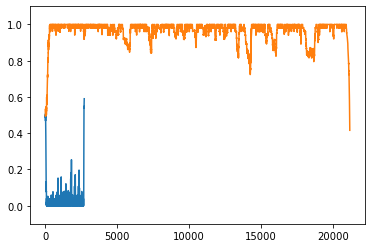

In [130]:
import matplotlib.pyplot as plt

 
plt.plot(list(range(0, len(ProbPlayer2.state['KQ11']))), ProbPlayer2.state['KQ11'])
plt.plot(list(range(0, len(ProbPlayer2.state['KQ10']))), ProbPlayer2.state['KQ10'])
plt.gca().set_ylim([-0.1, 1.1])
plt.show()

If Player 1 is dealt a King and the Community Card is a king, the probability of Player1 winning on bet (orange) vs check (blue) over many epochs is shown. Over time, the RL agent realizes that two Kings is the best hand and betting is the dominant strategy.

In [131]:
import numpy as np
import pandas as pd
hands = ['KK', 'QQ', 'JJ', 'KQ', 'QK', 'KJ', 'JK', 'QJ', 'JQ']
p1_moves1 = ['0', '1']
p1_moves2 = ['011', '010']
p2_moves_p1check = ['00', '01'] 
p2_moves_p1bet = ['10', '11']
p1_strategy1 = np.array([np.zeros(2)]*len(hands))
p1_strategy2 = np.array([np.zeros(2)]*len(hands))
p2_strategy_p1check = np.array([np.zeros(2)]*len(hands))
p2_strategy_p1bet = np.array([np.zeros(2)]*len(hands))
for i in range(len(hands)):
    seq_check = hands[i]+p1_moves1[0]
    seq_bet = hands[i]+p1_moves1[1]
    p1_strategy1[i] = np.array([ProbPlayer1.state[seq_bet][-1], ProbPlayer1.state[seq_check][-1]])
for i in range(len(hands)):
    seq_check = hands[i]+p1_moves2[0]
    seq_bet = hands[i]+p1_moves2[1]
    p1_strategy2[i] = np.array([ProbPlayer1.state[seq_bet][-1], ProbPlayer1.state[seq_check][-1]])
for i in range(len(hands)):
    seq_check = hands[i]+p2_moves_p1check[0]
    seq_bet = hands[i]+p2_moves_p1check[1]
    p2_strategy_p1check[i] = np.array([ProbPlayer2.state[seq_bet][-1], ProbPlayer2.state[seq_check][-1]])
for i in range(len(hands)):
    seq_check = hands[i]+p2_moves_p1bet[0]
    seq_bet = hands[i]+p2_moves_p1bet[1]
    p2_strategy_p1bet[i] = np.array([ProbPlayer2.state[seq_bet][-1], ProbPlayer2.state[seq_check][-1]])

## PLAYER 1 BETTING STRATEGY

### First Move

On the first move, here are the winning probabilities of betting vs checking based on hand:

In [132]:
p1_strategy1 = pd.DataFrame(p1_strategy1)
p1_strategy1 = p1_strategy1.rename(columns = {0:"Bet", 1:"Check"})
p1_strategy1.index = hands
p1_strategy1

,Bet,Check
KK,0.657024,0.348218
QQ,0.118150,0.880932
JJ,0.766720,0.231852
KQ,1.000000,0.000000
QK,1.000000,0.000000
KJ,1.000000,0.000000
JK,1.000000,0.000000
QJ,1.000000,0.000000
JQ,1.000000,0.000000


### Second Move

If Player 1 initially checks, and Player 2 bets, Player 1 will have another move. In this case, Player 1 can either call Player 2's bet, or fold.

In [133]:
p1_strategy2 = pd.DataFrame(p1_strategy2)
p1_strategy2 = p1_strategy2.rename(columns = {0:"Call", 1:"Fold"})
p1_strategy2.index = hands
p1_strategy2

,Call,Fold
KK,0.050746,0.950246
QQ,0.144700,0.854259
JJ,0.095524,0.906328
KQ,1.000000,0.000000
QK,1.000000,0.000000
KJ,1.000000,0.000000
JK,1.000000,0.000000
QJ,1.000000,0.000000
JQ,1.000000,0.000000


## PLAYER 2 BETTING STRATEGY

Player 2's betting strategy is dependent on Player 1's first move.

### If Player 1 Bets:

In [134]:
p2_strategy_p1bet = pd.DataFrame(p2_strategy_p1bet)
p2_strategy_p1bet = p2_strategy_p1bet.rename(columns = {0:"Call", 1:"Fold"})
p2_strategy_p1bet.index = hands
p2_strategy_p1bet

,Call,Fold
KK,0.783727,0.220333
QQ,0.927598,0.073840
JJ,0.491022,0.510713
KQ,0.590242,0.416048
QK,0.989466,0.010740
KJ,0.092139,0.908765
JK,0.000000,1.000000
QJ,0.000000,1.000000
JQ,0.000000,1.000000


### If Player 1 Checks:

In [135]:
p2_strategy_p1check = pd.DataFrame(p2_strategy_p1check)
p2_strategy_p1check = p2_strategy_p1check.rename(columns = {0:"Bet", 1:"Check"})
p2_strategy_p1check.index = hands
p2_strategy_p1check

,Bet,Check
KK,0.682757,0.322703
QQ,0.828256,0.175045
JJ,0.832476,0.169337
KQ,0.976319,0.024138
QK,0.713545,0.289007
KJ,0.056436,0.944122
JK,1.000000,0.000000
QJ,1.000000,0.000000
JQ,1.000000,0.000000


## COUNTERFACTUAL REGRET MINIMIZATION (CRM): for Leduc Poker

Referenced and adapted from Kuhn Poker CRM pseudocode: http://modelai.gettysburg.edu/2013/cfr/cfr.pdf

In [136]:
from typing import List, Dict
import itertools
import random
import numpy as np

class InformationSet():
    def __init__(self):
        
        self.cumulative_regrets = np.zeros(2)
        self.strategy_sum = np.zeros(2)

    def normalize(self, strategy: np.array):
        
        if sum(strategy) > 0:
            strategy /= sum(strategy)
        else:
            strategy = np.array([1/2, 1/2])
        return strategy

    def get_strategy(self, reach_probability: float) -> np.array:
        """Return regret-matching strategy"""
        strategy = np.maximum(0, self.cumulative_regrets)
        strategy = self.normalize(strategy)

        self.strategy_sum += reach_probability * strategy
        return strategy

    def get_average_strategy(self) -> np.array:
        return self.normalize(self.strategy_sum.copy())


class LeducPoker():
    def is_terminal(history):
        if history in ['10', '11', '00', '011', '010']:
            return True
        else:
            return False
        
    def showdownValue(hand)->int:
    
        ranks = {
            'KK': 6,
            'QQ': 5,
            'JJ': 4,
            'KQ': 3, 'QK': 3,
            'KJ': 2, 'JK': 2,
            'QJ': 1, 'JQ': 1
        }
        return ranks[hand]

    def get_payoff(history: str, cards: List[str], comm_card: str) -> int:
        """get payoff for 'active' player in terminal history"""
        if history in ['10', '010']: # If game had a bet but ended in check, active player gets $1
            return 1
        
        else:  # 00 or 11 or 011
            payoff = 2 if '1' in history else 1 # If there was a bet payoff is $2, otherwise $1
            active_player = len(history) % 2
            player_hand = cards[active_player] + comm_card
            opponent_hand = cards[(active_player + 1) % 2] + comm_card
            
            if LeducPoker.showdownValue(player_hand) > LeducPoker.showdownValue(opponent_hand):
                return payoff
            else:
                return -payoff


class LeducCFRTrainer():
    def __init__(self):
        self.infoset_map: Dict[str, InformationSet] = {}

    def get_information_set(self, history: str) -> InformationSet:
        """add if needed and return"""
        if history not in self.infoset_map:
            self.infoset_map[history] = InformationSet()
        return self.infoset_map[history]

    def cfr(self, cards: List[str], history: str, reach_probabilities: np.array, active_player: int, comm_card):
        if LeducPoker.is_terminal(history):
            return LeducPoker.get_payoff(history, cards, comm_card)

        my_hand = cards[active_player] + comm_card
        info_set = self.get_information_set(my_hand + history)

        strategy = info_set.get_strategy(reach_probabilities[active_player])
        opponent = (active_player + 1) % 2
        counterfactual_values = np.zeros(2)

        action_probability = strategy[0]
        # compute new reach probabilities after this action
        new_reach_probabilities = reach_probabilities.copy()
        new_reach_probabilities[active_player] *= action_probability
        # recursively call cfr method, next player to act is the opponent
        counterfactual_values[0] = -self.cfr(cards, history + '0', new_reach_probabilities, opponent, comm_card)
        
        action_probability = strategy[1]
        # compute new reach probabilities after this action
        new_reach_probabilities = reach_probabilities.copy()
        new_reach_probabilities[active_player] *= action_probability
        # recursively call cfr method, next player to act is the opponent
        counterfactual_values[1] = -self.cfr(cards, history + '1', new_reach_probabilities, opponent, comm_card)
        

        # Value of the current game state is just counterfactual values weighted by action probabilities
        state_value = counterfactual_values.dot(strategy)
        
        info_set.cumulative_regrets[0] += reach_probabilities[opponent] * (counterfactual_values[0] - state_value)
        info_set.cumulative_regrets[1] += reach_probabilities[opponent] * (counterfactual_values[1] - state_value)
        # if my_hand=='JQ':
        #     if history == '':
        #         print(info_set.get_average_strategy())
        return state_value

    def train(self, num_iterations: int) -> int:
        util = 0
        leduc_cards = ['J', 'Q', 'K','J', 'Q', 'K']
        for _ in range(num_iterations):
            sample = random.sample(leduc_cards, 3)
            cards = sample[:2]
            comm_card = sample[2]
            history = ''
            reach_probabilities = np.ones(2)
            util += self.cfr(cards, history, reach_probabilities, 0, comm_card)
        return util



num_iterations = 100000
np.set_printoptions(precision=2, floatmode='fixed', suppress=True)

cfr_trainer = LeducCFRTrainer()
util = cfr_trainer.train(num_iterations)
print(f"Average game value for Player 1: {(util / num_iterations)}\n")
lookup: Dict[str, List] = {}
print(f"History    Check/Fold    Bet/Call")
for name, info_set in sorted(cfr_trainer.infoset_map.items(), key=lambda s: len(s[0])):
    print(f"{name:6}:    {info_set.get_average_strategy()[0]:.3f}        {info_set.get_average_strategy()[1]:.3f}")
    lookup[name] = info_set.get_average_strategy()

Average game value for Player 1: -0.179285690249136

History    Check/Fold    Bet/Call
QJ    :    0.819        0.181
JQ    :    0.844        0.156
QQ    :    0.000        1.000
JK    :    0.826        0.174
KK    :    0.000        1.000
KQ    :    0.999        0.001
KJ    :    0.998        0.002
JJ    :    0.000        1.000
QK    :    1.000        0.000
KJ0   :    0.999        0.001
KJ1   :    0.170        0.830
KQ0   :    1.000        0.000
KQ1   :    0.177        0.823
QK0   :    0.999        0.001
QK1   :    0.150        0.850
JK0   :    0.839        0.161
JK1   :    0.999        0.001
QJ0   :    0.829        0.171
QJ1   :    0.993        0.007
JQ0   :    0.846        0.154
JQ1   :    0.996        0.004
QQ0   :    0.000        1.000
QQ1   :    0.000        1.000
KK0   :    0.000        1.000
KK1   :    0.000        1.000
JJ0   :    0.000        1.000
JJ1   :    0.000        1.000
QJ01  :    1.000        0.000
JQ01  :    0.999        0.001
QQ01  :    0.500        0.500
JK01  :    1.

In [137]:
def LeducPokerPvC(Player1, Player2):
    
    # initialize cards
    cards = ['J', 'J', 'Q', 'Q', 'K', 'K']
    
    # initialize money pot
    pot = 0
    
    s = random.sample(cards, 3)

    Player1.card = s[0]
    Player2.card = s[1]
    community_card = s[2]
    
    p2 = [Player2.card + community_card]
    
    print("Player 1 Card:", Player1.card)
    print("Player 1 Balance:", Player1.balance)
    print()
    print("Player 2 Card not shown")
    print("Player 2 Balance:", Player2.balance)
    print()
    print("Community Card:", community_card)
    print()
    print()
    
    print("Initial bets of 1 made")
    print()
    
    # add initial ante to the pot
    Player1.balance -= 1
    Player2.balance -= 1
    pot += 2
    
    # first action by Player 1
    print("Player 1 Balance", Player1.balance)
    print("Player 1, do you choose to check or bet")
    print("Press 0 for check, 1 to bet")
    print()
    player1_action1 = int(input())
    
    p2[0] += str(player1_action1)
    
    
    # execute if Player 1 checks
    if player1_action1 == 0:
        
        # first action by Player 2
        print("Player 2 Balance", Player2.balance)
        print()
        player2_action1 = random.choices([0,1], weights=lookup[p2[0]])[0]
        p2.append(p2[0] + str(player2_action1))
        
        if player2_action1 == 1:
            print("Player 2 bets")
        else:
            print("Player 2 checks")
        
        # execute if Player 2 checks
        if player2_action1 == 0:
    
            # showdown for the pot
        
            # Player 1 wins
            if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                Player1.balance += pot
                print("Player 1 Wins")
                print("Player 1 Card:", Player1.card)
                print("Player 1 Balance:", Player1.balance)
                print()
                print("Player 2 Card:", Player2.card)
                print("Player 2 Balance:", Player2.balance)
                print()
                pot = 0
                
            
            # Player 2 wins            
            elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                Player2.balance += pot
                print("Player 2 Wins")
                print("Player 1 Card:", Player1.card)
                print("Player 1 Balance:", Player1.balance)
                print()
                print("Player 2 Card:", Player2.card)
                print("Player 2 Balance:", Player2.balance)
                print()
                pot = 0
                
            # Tie Game
            else:
                Player1.balance += pot/2
                Player2.balance += pot/2
                pot = 0
                print("The rounds ended in a draw")
                return "Draw"
        
        # execute if Player 2 bets
        if player2_action1 == 1:
            
            # add to the pot from Player 2
            Player2.balance -= 1
            pot += 1
            
            # second action by Player 1
            print("Player 1 Balance", Player1.balance)
            print("Player 1, do you choose to fold or call")
            print("Press 0 for fold, 1 to call")
            print()
            player1_action2 = int(input())
            
            # execute if Player 1 folds
            if player1_action2 == 0:
                Player2.balance += pot
                print("Player 2 Wins")
                print("Player 1 Card:", Player1.card)
                print("Player 1 Balance:", Player1.balance)
                print()
                print("Player 2 Card:", Player2.card)
                print("Player 2 Balance:", Player2.balance)
                print()
                pot = 0
        
            # execute if Player 1 calls
            if player1_action2 == 1:
            
                # add to the pot from Player 1
                Player1.balance -= 1
                pot += 1
            
                # showdown for the pot
                
                # Player 1 wins
                if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                    Player1.balance += pot
                    print("Player 1 Wins")
                    print("Player 1 Card:", Player1.card)
                    print("Player 1 Balance:", Player1.balance)
                    print()
                    print("Player 2 Card:", Player2.card)
                    print("Player 2 Balance:", Player2.balance)
                    print()
                    pot = 0
                
            
                # Player 2 wins            
                elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                    Player2.balance += pot
                    print("Player 2 Wins")
                    print("Player 1 Card:", Player1.card)
                    print("Player 1 Balance:", Player1.balance)
                    print()
                    print("Player 2 Card:", Player2.card)
                    print("Player 2 Balance:", Player2.balance)
                    print()
                    pot = 0
                    
                
                # Tie Game
                else:
                    Player1.balance += pot/2
                    Player2.balance += pot/2
                    pot = 0
                    print("The rounds ended in a draw")
                    return "Draw"
            
    
    # execute if Player 1 bets
    if player1_action1 == 1:
        
        # add to the pot from Player 1
        Player1.balance -= 1
        pot += 1
        
        # first action by Player 2
        print("Player 2 Balance", Player2.balance)
        print()
        player2_action1 = random.choices([0,1], weights=lookup[p2[0]])[0]
        p2.append(p2[0] + str(player2_action1))
        
        if player2_action1 == 1:
            print("Player 2 calls")
        else:
            print("Player 2 fold")
        
        # execute if Player 2 folds
        if player2_action1 == 0:
            Player1.balance += pot
            print("Player 1 Wins")
            print("Player 1 Card:", Player1.card)
            print("Player 1 Balance:", Player1.balance)
            print()
            print("Player 2 Card:", Player2.card)
            print("Player 2 Balance:", Player2.balance)
            print()
            pot = 0
        
        # execute if Player 2 calls
        if player2_action1 == 1:
            
            # add to the pot from Player 2
            Player2.balance -= 1
            pot += 1
            
            # showdown for the pot
                
            # Player 1 wins
            if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                Player1.balance += pot
                print("Player 1 Wins")
                print("Player 1 Card:", Player1.card)
                print("Player 1 Balance:", Player1.balance)
                print()
                print("Player 2 Card:", Player2.card)
                print("Player 2 Balance:", Player2.balance)
                print()
                pot = 0
                
            
            # Player 2 wins            
            elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                Player2.balance += pot
                print("Player 2 Wins")
                print("Player 1 Card:", Player1.card)
                print("Player 1 Balance:", Player1.balance)
                print()
                print("Player 2 Card:", Player2.card)
                print("Player 2 Balance:", Player2.balance)
                print()
                pot = 0
            
            # Tie Game
            else:
                Player1.balance += pot/2
                Player2.balance += pot/2
                pot = 0
                print("The rounds ended in a draw")
                return "Draw"

In [138]:
def LeducPokerRandomChoicesCRM(Player1, Player2):
    
    # initialize cards
    cards = ['J', 'J', 'Q', 'Q', 'K', 'K']
    
    # initialize money pot
    pot = 0
    
    # randomly assign cards
    s = random.sample(cards, 3)

    Player1.card = s[0]
    Player2.card = s[1]
    community_card = s[2]
    
    
    p1 = [Player1.card + community_card]
    p2 = [Player2.card + community_card]
    
    p1b = Player1.balance
    p2b = Player2.balance
    
    # add initial ante to the pot
    Player1.balance -= 1
    Player2.balance -= 1
    pot += 2
    
    
    # first action by Player 1
    player1_action1 = random.choices([0,1], weights=lookup[p1[0]])[0]
    
    
    p1[0] += str(player1_action1)
    p2[0] += str(player1_action1)
    
    
    # execute if Player 1 checks
    if player1_action1 == 0:
        
        # first action by Player 2
        player2_action1 = random.choices([0,1], weights=lookup[p2[0]])[0]
            
        p1.append(p1[0] + str(player2_action1))
        p2.append(p2[0] + str(player2_action1))
        
        # execute if Player 2 checks
        if player2_action1 == 0:
    
            # showdown for the pot
        
            # Player 1 wins
            if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                Player1.balance += pot
                pot = 0
                Player1.wins += 1
                
                
            
            # Player 2 wins            
            elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                Player2.balance += pot
                pot = 0
                Player2.wins += 1
                
                
            # Tie Game
            else:
                Player1.balance += pot/2
                Player2.balance += pot/2
                pot = 0
        
        # execute if Player 2 bets
        if player2_action1 == 1:
            
            # add to the pot from Player 2
            Player2.balance -= 1
            pot += 1
            
            # second action by Player 1
            player1_action2 = random.choices([0,1], weights=lookup[p1[1]])[0]
                
            p1.append(p1[1] + str(player1_action2))
            p2.append(p2[1] + str(player1_action2))
            
            # execute if Player 1 folds
            if player1_action2 == 0:
                Player2.balance += pot
                pot = 0
                Player2.wins += 1
                
        
            # execute if Player 1 calls
            if player1_action2 == 1:
            
                # add to the pot from Player 1
                Player1.balance -= 1
                pot += 1
            
                # showdown for the pot
                
                # Player 1 wins
                if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                    Player1.balance += pot
                    pot = 0
                    Player1.wins += 1
                    
                
            
                # Player 2 wins            
                elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                    Player2.balance += pot
                    pot = 0
                    Player2.wins += 1
                
                # Tie Game
                else:
                    Player1.balance += pot/2
                    Player2.balance += pot/2
                    pot = 0
            
    
    # execute if Player 1 bets
    if player1_action1 == 1:
        
        # add to the pot from Player 1
        Player1.balance -= 1
        pot += 1
        
        # first action by Player 2
        player2_action1 = random.choices([0,1], weights=lookup[p2[0]])[0]
            
        p1.append(p1[0] + str(player2_action1))
        p2.append(p2[0] + str(player2_action1))
        
        # execute if Player 2 folds
        if player2_action1 == 0:
            Player1.balance += pot
            pot = 0
            Player1.wins += 1
            
        
        # execute if Player 2 calls
        if player2_action1 == 1:
            
            # add to the pot from Player 2
            Player2.balance -= 1
            pot += 1
            
            # showdown for the pot
                
            # Player 1 wins
            if showdownValue(Player1.card, community_card) > showdownValue(Player2.card, community_card):
                Player1.balance += pot
                pot = 0
                Player1.wins += 1
                
            
            # Player 2 wins            
            elif showdownValue(Player2.card, community_card) > showdownValue(Player1.card, community_card):
                Player2.balance += pot
                pot = 0
                Player2.wins += 1
            
            # Tie Game
            else:
                Player1.balance += pot/2
                Player2.balance += pot/2
                pot = 0

In [139]:
class CRMPlayer:
    def __init__(self, balance, card, wins):
        self.balance = balance
        self.card = card
        self.wins = wins

def competeCRM_v1(epochs, p1, p2):
    for i in range(1, epochs + 1):
        LeducPokerRandomChoicesCRM(p1, p2)
    print("Player 1 balance:", Player1.balance)
    print("Player 2 balance:", Player2.balance)
def competeCRM_v2(epochs, p1, p2):
    for i in range(1, int(epochs/2) + 1):
        LeducPokerRandomChoicesCRM(p1, p2)
        LeducPokerRandomChoicesCRM(p2, p1)
    print("Player 1 balance:", Player1.balance)
    print("Player 2 balance:", Player2.balance)

### Balances after 100000 rounds when Player 1 always goes first

In [144]:
Player1 = CRMPlayer(1000, '', 0)
Player2 = CRMPlayer(1000, '', 0)

competeCRM_v1(100000, Player1, Player2)

Player 1 balance: -774.0
Player 2 balance: 2774.0


### Balances after 100000 rounds when both players alternate:

In [146]:
Player1 = CRMPlayer(1000, '', 0)
Player2 = CRMPlayer(1000, '', 0)

competeCRM_v2(100000, Player1, Player2)

Player 1 balance: 992.0
Player 2 balance: 1008.0


# Play Against the CRM RL Agent!

In [100]:
Player1 = HumanPlayer(1000, '', 0)
Player2 = AIPlayer(1000, '', 0, 0, 0, s2)
for i in range(10):
    print(f"**************** Game {i+1}: ****************")
    LeducPokerPvC(Player1, Player2)
    print( "---------------------------------------------")

**************** Game 1: ****************
Player 1 Card: J
Player 1 Balance: 1000

Player 2 Card not shown
Player 2 Balance: 1000

Community Card: K


Initial bets of 1 made

Player 1 Balance 999
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 0


Player 2 Balance 999

Player 2 bets
Player 1 Balance 999
Player 1, do you choose to fold or call
Press 0 for fold, 1 to call



 0


Player 2 Wins
Player 1 Card: J
Player 1 Balance: 999

Player 2 Card: Q
Player 2 Balance: 1001

---------------------------------------------
**************** Game 2: ****************
Player 1 Card: Q
Player 1 Balance: 999

Player 2 Card not shown
Player 2 Balance: 1001

Community Card: Q


Initial bets of 1 made

Player 1 Balance 998
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 1


Player 2 Balance 1000

Player 2 fold
Player 1 Wins
Player 1 Card: Q
Player 1 Balance: 1000

Player 2 Card: J
Player 2 Balance: 1000

---------------------------------------------
**************** Game 3: ****************
Player 1 Card: J
Player 1 Balance: 1000

Player 2 Card not shown
Player 2 Balance: 1000

Community Card: K


Initial bets of 1 made

Player 1 Balance 999
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 0


Player 2 Balance 999

Player 2 checks
The rounds ended in a draw
---------------------------------------------
**************** Game 4: ****************
Player 1 Card: K
Player 1 Balance: 1000.0

Player 2 Card not shown
Player 2 Balance: 1000.0

Community Card: J


Initial bets of 1 made

Player 1 Balance 999.0
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 1


Player 2 Balance 999.0

Player 2 calls
The rounds ended in a draw
---------------------------------------------
**************** Game 5: ****************
Player 1 Card: K
Player 1 Balance: 1000.0

Player 2 Card not shown
Player 2 Balance: 1000.0

Community Card: K


Initial bets of 1 made

Player 1 Balance 999.0
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 1


Player 2 Balance 999.0

Player 2 fold
Player 1 Wins
Player 1 Card: K
Player 1 Balance: 1001.0

Player 2 Card: J
Player 2 Balance: 999.0

---------------------------------------------
**************** Game 6: ****************
Player 1 Card: J
Player 1 Balance: 1001.0

Player 2 Card not shown
Player 2 Balance: 999.0

Community Card: K


Initial bets of 1 made

Player 1 Balance 1000.0
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 0


Player 2 Balance 998.0

Player 2 checks
Player 2 Wins
Player 1 Card: J
Player 1 Balance: 1000.0

Player 2 Card: Q
Player 2 Balance: 1000.0

---------------------------------------------
**************** Game 7: ****************
Player 1 Card: J
Player 1 Balance: 1000.0

Player 2 Card not shown
Player 2 Balance: 1000.0

Community Card: K


Initial bets of 1 made

Player 1 Balance 999.0
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 0


Player 2 Balance 999.0

Player 2 checks
Player 2 Wins
Player 1 Card: J
Player 1 Balance: 999.0

Player 2 Card: Q
Player 2 Balance: 1001.0

---------------------------------------------
**************** Game 8: ****************
Player 1 Card: K
Player 1 Balance: 999.0

Player 2 Card not shown
Player 2 Balance: 1001.0

Community Card: Q


Initial bets of 1 made

Player 1 Balance 998.0
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 1


Player 2 Balance 1000.0

Player 2 fold
Player 1 Wins
Player 1 Card: K
Player 1 Balance: 1000.0

Player 2 Card: J
Player 2 Balance: 1000.0

---------------------------------------------
**************** Game 9: ****************
Player 1 Card: Q
Player 1 Balance: 1000.0

Player 2 Card not shown
Player 2 Balance: 1000.0

Community Card: K


Initial bets of 1 made

Player 1 Balance 999.0
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 1


Player 2 Balance 999.0

Player 2 fold
Player 1 Wins
Player 1 Card: Q
Player 1 Balance: 1001.0

Player 2 Card: J
Player 2 Balance: 999.0

---------------------------------------------
**************** Game 10: ****************
Player 1 Card: J
Player 1 Balance: 1001.0

Player 2 Card not shown
Player 2 Balance: 999.0

Community Card: J


Initial bets of 1 made

Player 1 Balance 1000.0
Player 1, do you choose to check or bet
Press 0 for check, 1 to bet



 1


Player 2 Balance 998.0

Player 2 calls
Player 1 Wins
Player 1 Card: J
Player 1 Balance: 1003.0

Player 2 Card: K
Player 2 Balance: 997.0

---------------------------------------------


We won $3 against the CRM-trained RL Agent